# The Smith Parasite Project <img align='right' width='100' height='125' src='https://maiseducativa.com/wp-content/uploads/2015/02/Logo_Nova-IMS.jpg'>

## <font color='SeaGreen'>__Models__</font><br>

### <font color='SeaGreen'> 1. Data Collection </font>
Libraries, data file path, and importing of the data

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.neural_network import MLPClassifier, MLPRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import warnings 
warnings.filterwarnings('ignore')

In [2]:
current_path = os.getcwd() # current directory (dir)
path = os.path.join(current_path,'the-smith-parasite-dataset') # joins data folder dir

# Train data
train_data = pd.read_csv(os.path.join(path, 'train_data.csv'), index_col=0)

# Test data
test_data = pd.read_csv(os.path.join(path, 'test_data.csv'), index_col=0)

In [3]:
train_data.drop(['BMI','Age'], axis=1, inplace=True)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 1167 to 1117
Data columns (total 44 columns):
 #   Column                                                                               Non-Null Count  Dtype
---  ------                                                                               --------------  -----
 0   Height                                                                               775 non-null    int64
 1   Weight                                                                               775 non-null    int64
 2   High_Cholesterol                                                                     775 non-null    int64
 3   Blood_Pressure                                                                       775 non-null    int64
 4   Mental_Health                                                                        775 non-null    int64
 5   Physical_Health                                                                      775 non-null    i

In [5]:
train_data.head().style

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Birth_Year,Disease,Smoking_Habit,Exercise,Region_East Midlands,Region_East of England,Region_London,Region_North East,Region_North West,Region_South East,Region_South West,Region_West Midlands,Region_Yorkshire and the Humber,Education_Elementary School (1st to 9th grade),Education_High School Graduate,Education_High School Incomplete (10th to 11th grade),Education_I never attended school / Other,Education_University Complete (3 or more years),Education_University Incomplete (1 to 2 years),Drinking_Habit_I consider myself a social drinker,Drinking_Habit_I do not consume any type of alcohol,Drinking_Habit_I usually consume alcohol every day,Fruit_Habit_1 to 2 pieces of fruit in average,Fruit_Habit_3 to 4 pieces of fruit in average,Fruit_Habit_5 to 6 pieces of fruit in average,Fruit_Habit_Less than 1. I do not consume fruits every day.,Fruit_Habit_More than six pieces of fruit,Water_Habit_Between one liter and two liters,Water_Habit_Less than half a liter,Water_Habit_More than half a liter but less than one liter,Checkup_Less than 3 years but more than 1 year,Checkup_Less than three months,Checkup_More than 3 years,Checkup_Not sure,Diabetes_I do have diabetes,"Diabetes_I don't have diabetes, but I have direct family members who have diabetes.",Diabetes_I have/had pregnancy diabetes or borderline diabetes,Diabetes_Neither I nor my immediate family have diabetes.
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1167,155,67,358,120,21,2,1965,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
1805,173,88,230,142,9,0,1969,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1
1557,162,68,226,122,26,0,1974,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
1658,180,66,313,125,13,8,1958,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
1544,180,58,277,125,18,2,1968,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [6]:
# Setting seed for reproducibility of results #0 
#np.random.seed(0)

# Defining X and y
y = train_data['Disease'].copy()
X = train_data.drop('Disease', axis = 1).copy()

# Applying SMOTE to generare new instances (over-sampling)
#smote = SMOTE(random_state = seed, sampling_strategy = 1)
#X_train, y_train = smote.fit_resample(X_train, y_train)

entropy_importance = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X, y)

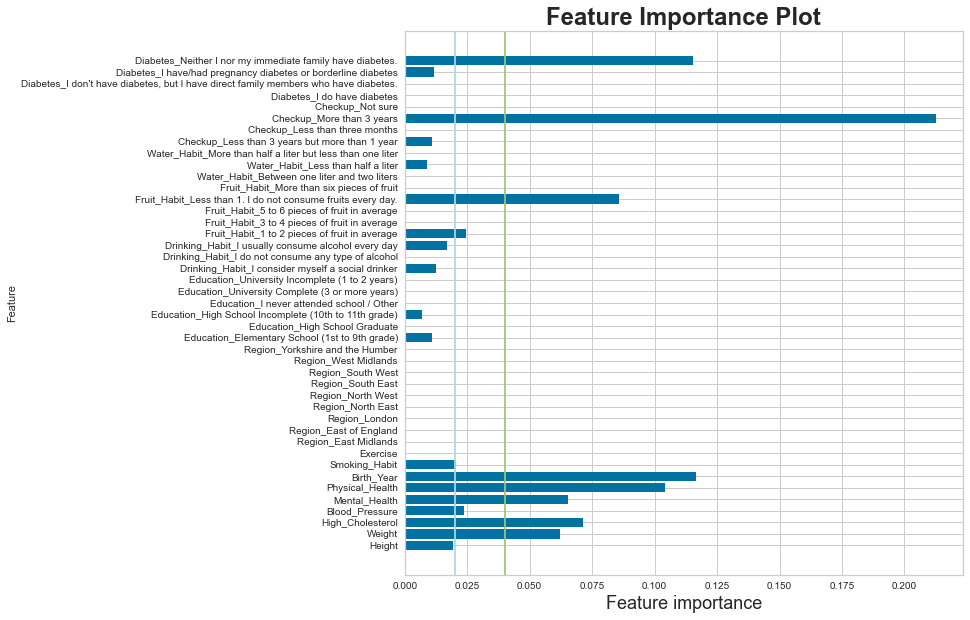

In [7]:
# Plotting feature importance

def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(10,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.title('Feature Importance Plot',fontsize=24, fontweight='bold')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel('Feature importance', fontsize=18) 
    plt.ylabel('Feature') 
    plt.axvline(x=0.02, color = 'lightblue') 
    plt.axvline(x=0.04, color = 'g') 
    plt.show()
     
plot_feature_importances(entropy_importance, X)

In [8]:
# Creating dataset with features with importance above .04 (green line in plot above)
def df_feature_importances(model, data):
    col_names = []
    col_importance = []
    for idx, col in enumerate(data): 
        col_names.append(col)
        col_importance.append(model.feature_importances_[idx])
    ft_importance_df=pd.DataFrame({'Features' : col_names, 'Importance' : col_importance})
    ft_importance_df=ft_importance_df.sort_values('Importance',ascending = False)
    ft_importance_df=ft_importance_df.loc[ft_importance_df.Importance > .02].reset_index().drop('index',axis=1)
    return ft_importance_df

df_feature_importances(entropy_importance, X).style

NumExpr defaulting to 8 threads.


,Features,Importance
0,Checkup_More than 3 years,0.212740
1,Birth_Year,0.116557
2,Diabetes_Neither I nor my immediate family have diabetes.,0.115531
3,Physical_Health,0.104221
4,Fruit_Habit_Less than 1. I do not consume fruits every day.,0.085641
5,High_Cholesterol,0.071505
6,Mental_Health,0.065296
7,Weight,0.062242
8,Fruit_Habit_1 to 2 pieces of fruit in average,0.024393
9,Blood_Pressure,0.023676


In [25]:
important_cols

array(['Checkup_More than 3 years', 'Birth_Year',
       'Diabetes_Neither I nor my immediate family have diabetes.',
       'Physical_Health',
       'Fruit_Habit_Less than 1. I do not consume fruits every day.',
       'High_Cholesterol', 'Mental_Health', 'Weight',
       'Fruit_Habit_1 to 2 pieces of fruit in average', 'Blood_Pressure',
       'Smoking_Habit'], dtype=object)

In [9]:
important_cols = df_feature_importances(entropy_importance,X)['Features'].values
X = X[important_cols]

In [10]:
# Setting random state seeds
seed = 1

# Split the data in a stratify way, leaving 25% in the hold out sample 

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = seed,
                                                    test_size = .2,
                                                    #stratify = y
                                                   )


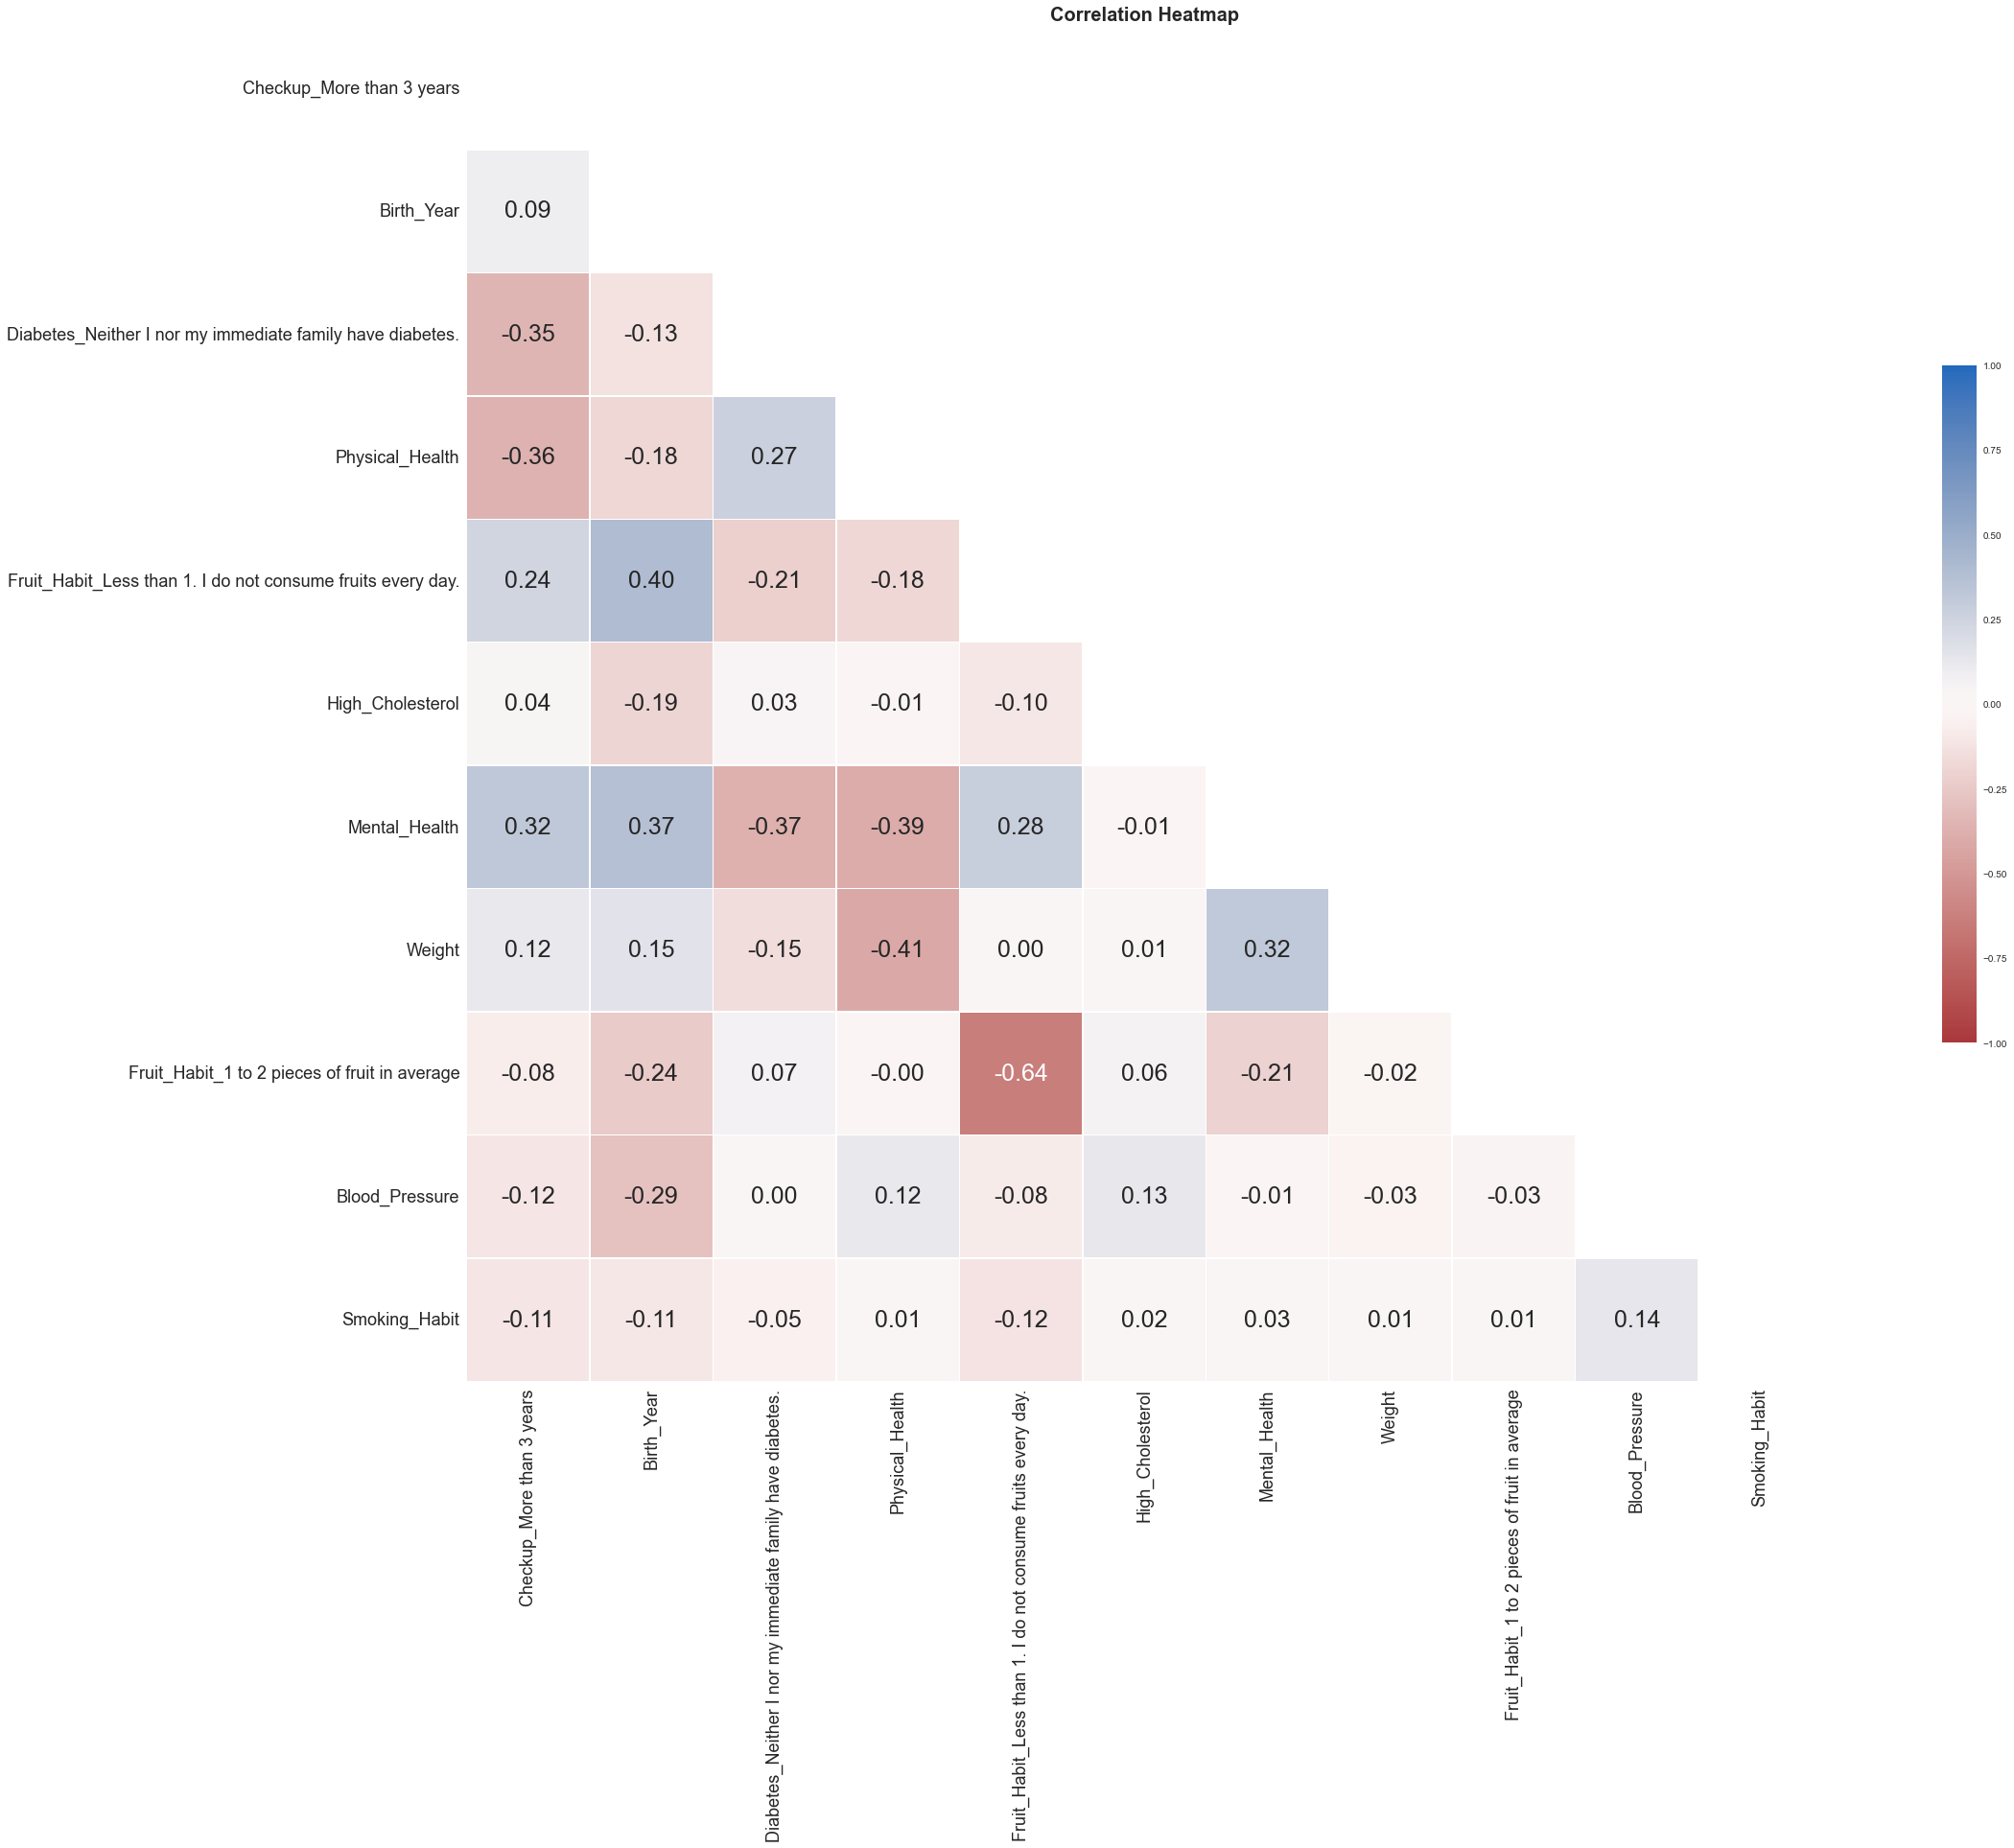

In [11]:
# Correlations analysis
# Plot
cmap = sns.color_palette('vlag_r', as_cmap=True)

# Computing the correlation matrix
corr = X_train.corr('spearman')

# Generating a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


plt.figure(figsize = (45, 26))
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, vmin = -1, center = 0,
            square = True, linewidths = .5, cbar_kws = {'shrink': .5}, annot = True, fmt = '.2f', 
           annot_kws={'size':25})

#customize
plt.title('Correlation Heatmap',fontsize = 20, fontweight = 'bold')


plt.show()

In [12]:
#X_train.drop(['Age','Weight'],axis=1,inplace=True)
#X_test.drop(['Age','Weight'],axis=1,inplace=True)

In [12]:
#X_train.drop('Age',axis=1,inplace=True)
#X_test.drop('Age',axis=1,inplace=True)

In [13]:
#X_train.drop(['Birth_Year'],axis=1,inplace=True)
#X_test.drop(['Birth_Year'],axis=1,inplace=True)

In [14]:
# Helper functions

def evaluate_model(model, X, y):
    kf = StratifiedShuffleSplit(n_splits=10, random_state=seed)
    score_train = []
    score_test = []
    timer = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        begin = time.perf_counter()
        model.fit(X_train, y_train)
        end = time.perf_counter()
        
        value_train = model.score(X_train, y_train)
        value_test = model.score(X_test,y_test)
        
        # Appends the accuracy, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end - begin)
        
    # Calculate the average and the std for each measure 
    # (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time),\
           str(avg_train) + '+/-' + str(std_train),\
           str(avg_test) + '+/-' + str(std_test)

In [15]:
# Function to create dataframe with metrics

def performance_metrics(y_Train,
                        y_PredTrain,
                        y_Test,
                        y_PredTest):
    '''
    Creates Dataframe with the main benchmark metrics for Classfication models
    
    Args: 
        y_Train -      Series with target values used to train model
        y_PredTrain -  Series with predicted values from y_Train
        y_Test -       Series with test values used to validate model
        y_PredTest -   Series with predicted values from y_Test
        
    Returns: 
        pandas.core.frame.DataFrame
    '''
    # Columns
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    
    # Results for train data
    train_results = [
                round(metrics.accuracy_score(y_Train, y_PredTrain),3),  # Calculating accuracy
                round(metrics.precision_score(y_Train, y_PredTrain),3),  # Calculating precision
                round(metrics.recall_score(y_Train, y_PredTrain),3),  # Calculating recall
                round(metrics.f1_score(y_Train, y_PredTrain),3),  # Calculating f1 score
                round(metrics.roc_auc_score(y_Train, y_PredTrain),3)  # Calculating ROC area under the curve
                ]
    # Results for test data
    test_results = [
               round(metrics.accuracy_score(y_Test, y_PredTest),3),  # Calculating accuracy
               round(metrics.precision_score(y_Test, y_PredTest),3),  # Calculating precision
               round(metrics.recall_score(y_Test, y_PredTest),3),  # Calculating recall
               round(metrics.f1_score(y_Test, y_PredTest),3),  # Calculating f1 score
               round(metrics.roc_auc_score(y_Test, y_PredTest),3)  # Calculating ROC area under the curve
               ]
    
    results = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test': test_results})
    
    # Comparison column
    results['Difference'] = round(results['Train'] - results['Test'], 2) 
    
    return results

In [16]:
# Function to plot confusion matrix
# Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf,
                          group_names = None,
                          categories ='auto',
                          count = True,
                          percent = True,
                          cbar = True,
                          xyticks = True,
                          xyplotlabels = True,
                          sum_stats = True,
                          figsize = None,
                          cmap = 'Blues',
                          title = None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    
    Args: 
        cf -           Confusion matrix to be passed in
        group_names -  List of strings that represent the labels row by row to be shown in each square
        categories -   List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
        count -        If True, show the raw number in the confusion matrix. Default is True
        normalize -    If True, show the proportions for each category. Default is True
        cbar -         If True, show the color bar. The cbar values are based off the values in the confusion matrix
                       Default is True
        xyticks -      If True, show x and y ticks. Default is True
        xyplotlabels - If True, show 'True Label' and 'Predicted Label' on the figure. Default is True
        sum_stats -    If True, display summary statistics below the figure. Default is True
        figsize -      Tuple representing the figure size. Default will be the matplotlib rcParams value
        cmap -         Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
        title -        Title for the heatmap. Default is None
        
    Returns: 
        Confusion Matrix Plot
    '''
    # Generating text inside each matrix square
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ['{}\n'.format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ['{0:0.0f}\n'.format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f'{v1}{v2}{v3}'.strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


        # Generating summary statistics & text for summary stats
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = '\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}'.format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = '\n\nAccuracy={:0.3f}'.format(accuracy)
    else:
        stats_text = ''


    # Setting figure parameters according to other arguments
    if figsize == None:
        # Gets default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Doesn't show categories if xyticks is False
        categories = False

    # Making the heatmap vizualization
    plt.figure(figsize = figsize)
    ax = sns.heatmap(cf, 
                     annot = box_labels, fmt = '',
                     cmap = cmap, cbar = cbar,
                     xticklabels = categories,
                     yticklabels = categories)

    if xyplotlabels:
        plt.ylabel('True label', fontsize = 14)
        plt.xlabel('Predicted label' + stats_text, fontsize = 14)
    else:
        plt.xlabel(stats_text, fontsize = 14)
    
    if title:
        plt.title(title)

> ### Decision Tree

A Decision Tree is a model composed of a collection of questions organized hierarchically in the shape of a tree, usually represented with the root (the first node) at the top.<br><br> The questions are usually called a condition, a split, or a test. Each non-leaf node contains a condition, and each leaf node contains a prediction.

<img align='center' width='500' height='500' src='https://developers.google.com/static/machine-learning/decision-forests/images/DecisionTree.png'>

In [16]:
# Hiper Tuning Decision Tree

# Setting params
parameters = {'splitter': ('best', 'random'),
              'max_depth': (7, 9, 11, 13), 
              'min_samples_split' : (2, 4, 6),
              'class_weight': ('balanced', None)
              }

# Checking best parameters by highest f1 score obtained
DT_gridsearch = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'), parameters, scoring = 'f1', cv = 10)
DT_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(DT_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(DT_gridsearch.best_estimator_))



Grid search best parameters: {'class_weight': 'balanced', 'max_depth': 11, 'min_samples_split': 2, 'splitter': 'best'} 

Grid search best parameters: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11)


In [20]:
# Creating DT Model
seed = 10
DTmodel = DecisionTreeClassifier(class_weight = None,
                                 splitter = 'best',
                                 criterion = 'entropy',
                                 max_depth = 30,
                                 min_samples_split = 2, 
                                 random_state = seed)

DTmodel.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, random_state=10)

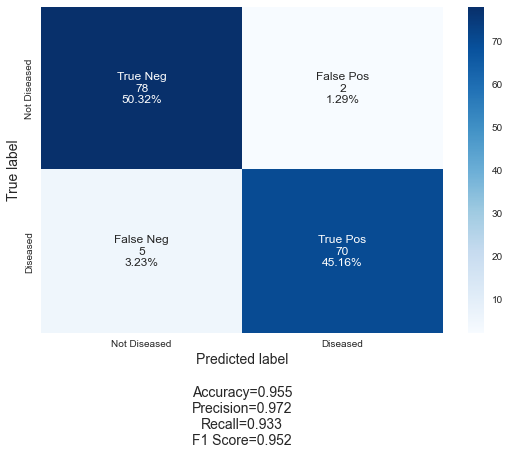

              precision    recall  f1-score   support

Not Diseased       0.94      0.97      0.96        80
    Diseased       0.97      0.93      0.95        75

    accuracy                           0.95       155
   macro avg       0.96      0.95      0.95       155
weighted avg       0.96      0.95      0.95       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.955,0.05
1,PRECISION,1.0,0.972,0.03
2,RECALL,1.0,0.933,0.07
3,F1 SCORE,1.0,0.952,0.05
4,AUC,1.0,0.954,0.05


In [21]:
# Predicting target for X_train and X_test
y_pred = DTmodel.predict(X_test)
y_pred_train = DTmodel.predict(X_train)

# Getting model scores
value_train = round(DTmodel.score(X_train, y_train), 3)
value_test = round(DTmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Layout (only needs to be defined once)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Diseased', 'Diseased']

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

> ### Random Forest

We can define the Random Forest Classifier as set of Decision Trees.

In [21]:
# Hiper Tuning Random Forest

# Setting params
parameters = {'criterion' : ('gini','entropy'), 
              'max_depth': np.linspace(10, 50, 5),
              'min_samples_split' : (2, 5, 10),
              }

# Checking best parameters by highest f1 score obtained
RF_gridsearch = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'f1', cv = 10)
RF_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(RF_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(RF_gridsearch.best_estimator_))



Grid search best parameters: {'criterion': 'gini', 'max_depth': 50.0, 'min_samples_split': 2} 

Grid search best parameters: RandomForestClassifier(max_depth=50.0)


In [19]:
# Setting params
parameters = {'max_features' : ('auto', 'log2'), 
              'min_samples_leaf' : (1, 2, 4),
              'bootstrap' : (True, False)
              }

# Checking best parameters by highest f1 score obtained
RF_gridsearch = GridSearchCV(RandomForestClassifier(criterion = 'gini',
                                                    max_depth = 50,
                                                    min_samples_split = 2),
                                                    parameters, scoring = 'f1', cv = 10)
RF_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(RF_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(RF_gridsearch.best_estimator_))


KeyboardInterrupt



In [23]:
# Creating RF Model #99 com ouliers colesterol sem 1800
RFmodel = RandomForestClassifier(criterion = 'entropy',
                                 max_depth = 10,
                                 min_samples_split = 2,
                                 max_features = 'auto',
                                 bootstrap = False,
                                 oob_score = False,
                                 warm_start = False,
                                 class_weight = 'balanced',
                                 min_samples_leaf = 1,
                                 random_state = seed
                                 )

RFmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=10, random_state=10)

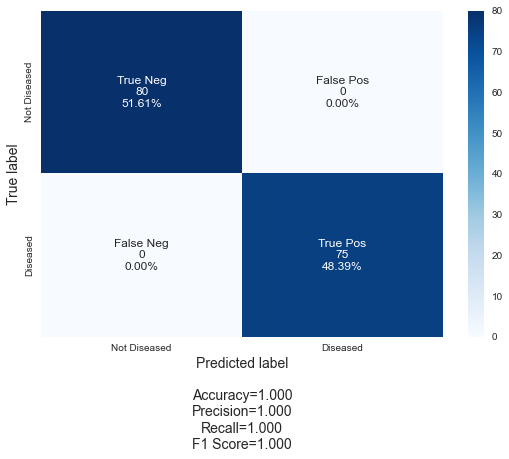

              precision    recall  f1-score   support

Not Diseased       1.00      1.00      1.00        80
    Diseased       1.00      1.00      1.00        75

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,1.0,0.0
1,PRECISION,1.0,1.0,0.0
2,RECALL,1.0,1.0,0.0
3,F1 SCORE,1.0,1.0,0.0
4,AUC,1.0,1.0,0.0


In [24]:
# Predicting target for X_train and X_test
y_pred = RFmodel.predict(X_test)
y_pred_train = RFmodel.predict(X_train)

# Getting model scores
value_train = round(RFmodel.score(X_train, y_train), 3)
value_test = round(RFmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   \033[1mBenchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

> ### AdaBoost Classifier

Ada-boost or Adaptive Boosting is one of ensemble boosting classifier that combines multiple classifiers to increase the accuracy of classifiers and can be used for both classification and regression problems.

The basic concept behind Adaboost is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. Any machine learning algorithm can be used as base classifier if it accepts weights on the training set. Adaboost should meet two conditions:

1. The classifier should be trained interactively on various weighed training examples.
2. In each iteration, it tries to provide an excellent fit for these examples by minimizing training error.

In [31]:
ADAmodel = AdaBoostClassifier(n_estimators = 100,
                              base_estimator = RFmodel,
                              algorithm = 'SAMME.R',
                              learning_rate = .1,
                              random_state = seed)

ADAmodel.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                         class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=10,
                                                         random_state=10),
                   learning_rate=0.1, n_estimators=100, random_state=10)

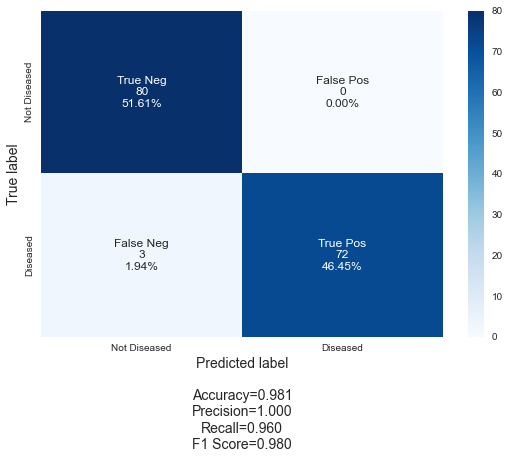

              precision    recall  f1-score   support

Not Diseased       0.96      1.00      0.98        80
    Diseased       1.00      0.96      0.98        75

    accuracy                           0.98       155
   macro avg       0.98      0.98      0.98       155
weighted avg       0.98      0.98      0.98       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.981,0.02
1,PRECISION,1.0,1.000,0.00
2,RECALL,1.0,0.960,0.04
3,F1 SCORE,1.0,0.980,0.02
4,AUC,1.0,0.980,0.02


In [32]:
# Predicting target for X_train and X_test
y_pred = ADAmodel.predict(X_test)
y_pred_train = ADAmodel.predict(X_train)

# Getting model scores
value_train = round(ADAmodel.score(X_train, y_train), 3)
value_test = round(ADAmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   \033[1mBenchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

> ### Gradient Boosting Classifier

Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

In [49]:
# Hiper Tuning Gradient Boosting Classifier

# Setting params

parameters = {'n_estimators': [2, 4, 8, 16, 32, 64, 100, 200],
              'learning_rate': [1, .5, .25, .1, .05, .01],
              'max_features': list(range(1, len(train_data.columns)))
              }

# Checking best parameters by highest f1 score obtained
GBC_gridsearch = GridSearchCV(GradientBoostingClassifier(), parameters, scoring = 'f1', cv = 5)
GBC_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(GBC_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(GBC_gridsearch.best_estimator_))



Grid search best parameters: {'learning_rate': 1, 'max_features': 1, 'n_estimators': 200} 

Grid search best parameters: GradientBoostingClassifier(learning_rate=1, max_features=1, n_estimators=200)


In [38]:
# Setting params

parameters = {'min_samples_split': np.linspace(.1, 1, 5),
              'min_samples_leaf': np.linspace(.1, 0.5, 5),
              'max_depth': np.linspace(1, 32, 32)
              }

# Checking best parameters by highest f1 score obtained
GBC_gridsearch = GridSearchCV(GradientBoostingClassifier(n_estimators = 200,
                                                         max_features = 1, 
                                                         learning_rate = 1), parameters, scoring = 'f1', cv = 5)
GBC_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(GBC_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(GBC_gridsearch.best_estimator_))


KeyboardInterrupt



In [33]:
# Creating GBC Model #99
GBCmodel = GradientBoostingClassifier(n_estimators = 200,
                                      warm_start = True,
                                      max_features = 5,
                                      learning_rate = 1,
                                      max_depth = 10, 
                                      min_samples_split = .1,
                                      min_samples_leaf = .01,
                                      tol = 1e-10,
                                      random_state = seed) 

GBCmodel.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=10, max_features=5,
                           min_samples_leaf=0.01, min_samples_split=0.1,
                           n_estimators=200, random_state=10, tol=1e-10,
                           warm_start=True)

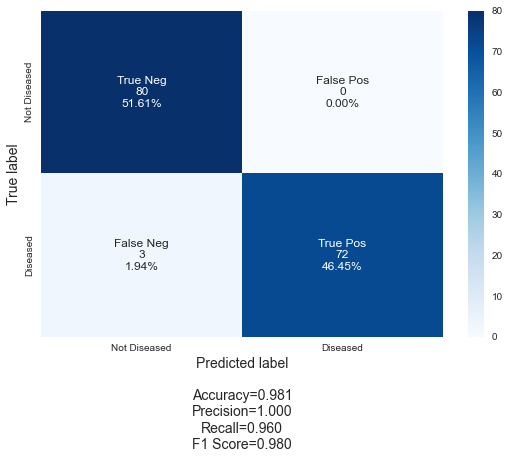

              precision    recall  f1-score   support

Not Diseased       0.96      1.00      0.98        80
    Diseased       1.00      0.96      0.98        75

    accuracy                           0.98       155
   macro avg       0.98      0.98      0.98       155
weighted avg       0.98      0.98      0.98       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.981,0.02
1,PRECISION,1.0,1.000,0.00
2,RECALL,1.0,0.960,0.04
3,F1 SCORE,1.0,0.980,0.02
4,AUC,1.0,0.980,0.02


In [34]:
# Predicting target for X_train and X_test
y_pred = GBCmodel.predict(X_test)
y_pred_train = GBCmodel.predict(X_train)

# Getting model scores
value_train = round(GBCmodel.score(X_train, y_train), 3)
value_test = round(GBCmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

In [35]:
x = pd.DataFrame({'Predictions':y_pred, 'Results':y_test})
x.loc[x['Predictions']!=x['Results']]

,Predictions,Results
PatientID,,
1036,0,1
1157,0,1
1673,0,1


In [29]:
train_data.loc[[1528]].style

,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Birth_Year,Disease,Smoking_Habit,Exercise,Age,BMI,Region_East Midlands,Region_East of England,Region_London,Region_North East,Region_North West,Region_South East,Region_South West,Region_West Midlands,Region_Yorkshire and the Humber,Education_Elementary School (1st to 9th grade),Education_High School Graduate,Education_High School Incomplete (10th to 11th grade),Education_I never attended school / Other,Education_University Complete (3 or more years),Education_University Incomplete (1 to 2 years),Drinking_Habit_I consider myself a social drinker,Drinking_Habit_I do not consume any type of alcohol,Drinking_Habit_I usually consume alcohol every day,Fruit_Habit_1 to 2 pieces of fruit in average,Fruit_Habit_3 to 4 pieces of fruit in average,Fruit_Habit_5 to 6 pieces of fruit in average,Fruit_Habit_Less than 1. I do not consume fruits every day.,Fruit_Habit_More than six pieces of fruit,Water_Habit_Between one liter and two liters,Water_Habit_Less than half a liter,Water_Habit_More than half a liter but less than one liter,Checkup_Less than 3 years but more than 1 year,Checkup_Less than three months,Checkup_More than 3 years,Checkup_Not sure,Diabetes_I do have diabetes,"Diabetes_I don't have diabetes, but I have direct family members who have diabetes.",Diabetes_I have/had pregnancy diabetes or borderline diabetes,Diabetes_Neither I nor my immediate family have diabetes.,Health_Segmentation,Habits_Segmentation
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1528,178,58,274,178,16,20,1963,1,0,0,59,0.326000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,3


> ### XGBoost Classifier

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [ ]:
# Setting params

parameters = {'n_estimators': [10,20,30],
              'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
              'max_features': [2,3,4,5,6],
              'max_depth': [2,3,4,5,6,7],
            }

RF_gridsearch = GridSearchCV(GradientBoostingClassifier(),parameters, cv = 5, scoring= 'f1')
RF_gridsearch.fit(X_train, y_train)
print('\n\n Grid search best parameters: {}'.format(RF_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(RF_gridsearch.best_estimator_))

In [36]:
# Creating XGB Model
#booster: Specify which booster to use: gbtree or dart gblinear
# tree_method: approx', 'auto', 'exact', 'gpu_hist', 'hist'
XGBmodel = XGBClassifier(n_estimators = 300,
                         booster = 'gbtree',
                         tree_method = 'exact',
                         max_depth = 10,
                         learning_rate = .1,
                         eta = .01,
                         #gamma = 1e-10,
                         #sampling_method = 'gradient_based',
                         random_state = seed) 

XGBmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.01,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, ...)

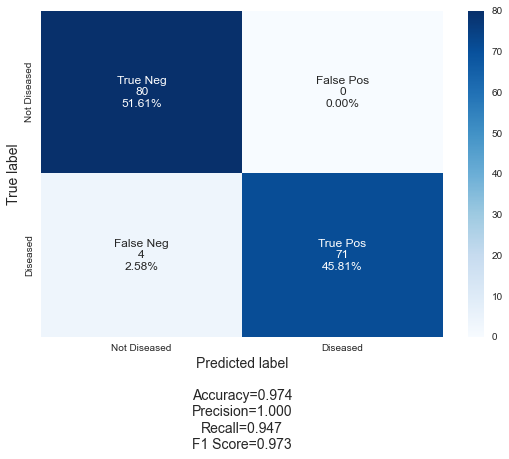

              precision    recall  f1-score   support

Not Diseased       0.95      1.00      0.98        80
    Diseased       1.00      0.95      0.97        75

    accuracy                           0.97       155
   macro avg       0.98      0.97      0.97       155
weighted avg       0.98      0.97      0.97       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.974,0.03
1,PRECISION,1.0,1.000,0.00
2,RECALL,1.0,0.947,0.05
3,F1 SCORE,1.0,0.973,0.03
4,AUC,1.0,0.973,0.03


In [37]:
# Predicting target for X_train and X_test
y_pred = XGBmodel.predict(X_test)
y_pred_train = XGBmodel.predict(X_train)

# Getting model scores
value_train = round(XGBmodel.score(X_train, y_train), 3)
value_test = round(XGBmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

In [26]:
# Stratifying data with Shuffle split & feature selection
evaluate_model(XGBmodel, X_train,y_train)

# Predicting again target for X_train and X_test 
y_pred = XGBmodel.predict(X_test)
y_pred_train = XGBmodel.predict(X_train)

# Getting new scores
value_train = round(XGBmodel.score(X_train, y_train), 3)
value_test = round(XGBmodel.score(X_test, y_test), 3)

# Comparing model results with stratified data & feature selection
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

,Measure,Train,Test,Difference
0,ACCURACY,0.997,0.987,0.01
1,PRECISION,0.994,0.987,0.01
2,RECALL,1.000,0.987,0.01
3,F1 SCORE,0.997,0.987,0.01
4,AUC,0.997,0.987,0.01


--- 
--- 
--- 
---

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
ETCmodel = ExtraTreesClassifier(criterion = 'entropy',
                                max_depth = 150,
                                min_samples_split = 2,
                                max_features = 'auto',
                                bootstrap = False,
                                oob_score = False,
                                warm_start = False,
                                class_weight = 'balanced',
                                min_samples_leaf = 1,
                                random_state=seed).fit(X_train, y_train)

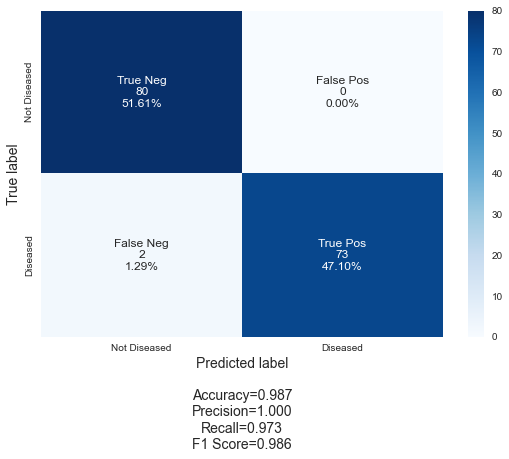

              precision    recall  f1-score   support

Not Diseased       0.98      1.00      0.99        80
    Diseased       1.00      0.97      0.99        75

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.987,0.01
1,PRECISION,1.0,1.000,0.00
2,RECALL,1.0,0.973,0.03
3,F1 SCORE,1.0,0.986,0.01
4,AUC,1.0,0.987,0.01


In [39]:
# Predicting target for X_train and X_test
y_pred = ETCmodel.predict(X_test)
y_pred_train = ETCmodel.predict(X_train)

# Getting model scores
value_train = round(ETCmodel.score(X_train, y_train), 3)
value_test = round(ETCmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

In [40]:
from sklearn.ensemble import HistGradientBoostingClassifier
HGBmodel = HistGradientBoostingClassifier(learning_rate = 1,
                                          max_depth = 10,
                                          loss = 'auto',
                                          random_state=seed).fit(X_train, y_train)

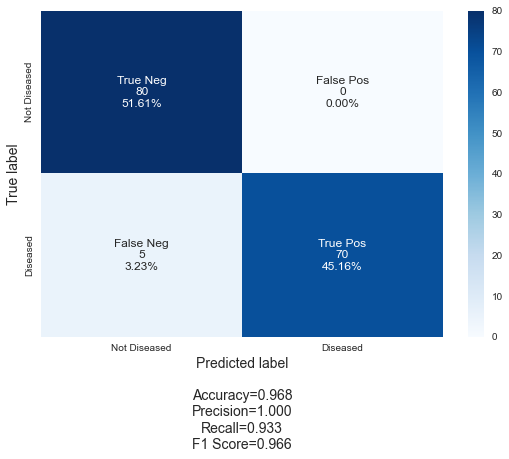

              precision    recall  f1-score   support

Not Diseased       0.94      1.00      0.97        80
    Diseased       1.00      0.93      0.97        75

    accuracy                           0.97       155
   macro avg       0.97      0.97      0.97       155
weighted avg       0.97      0.97      0.97       155



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.968,0.03
1,PRECISION,1.0,1.000,0.00
2,RECALL,1.0,0.933,0.07
3,F1 SCORE,1.0,0.966,0.03
4,AUC,1.0,0.967,0.03


In [41]:
# Predicting target for X_train and X_test
y_pred = HGBmodel.predict(X_test)
y_pred_train = HGBmodel.predict(X_train)

# Getting model scores
value_train = round(HGBmodel.score(X_train, y_train), 3)
value_test = round(HGBmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

--- 
--- 
--- 
---

> ### Normalization Study

#### MLPClassifier before scalling

In [31]:
classifier = MLPClassifier().fit(X_train, y_train)

classifier.score(X_test, y_test)

0.6928104575163399

#### MinMax Scaler 

In [32]:
min_max = MinMaxScaler().fit(X_train)
min_max_X_train = min_max.transform(X_train)
min_max_X_test = min_max.transform(X_test)
model_min_max = MLPClassifier().fit(min_max_X_train, y_train)
model_min_max.score(min_max_X_test, y_test)

0.8627450980392157

#### Rescale between [-1,1]

In [33]:
min_max2 = MinMaxScaler(feature_range = (-1, 1)).fit(X_train)
min_max2_X_train = min_max2.transform(X_train)
min_max2_X_test = min_max2.transform(X_test)
model_min_max2 = MLPClassifier().fit(min_max2_X_train, y_train)
model_min_max2.score(min_max2_X_test, y_test)

0.8627450980392157

#### The RobustScaler

In [34]:
robust = RobustScaler().fit(X_train)
robust_X_train = robust.transform(X_train)
robust_X_test = robust.transform(X_test)
model_robust = MLPClassifier().fit(robust_X_train, y_train)
model_robust.score(robust_X_test, y_test)

0.8954248366013072

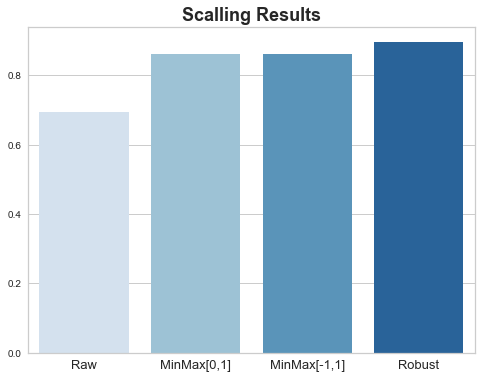

In [35]:
x = ['Raw','MinMax[0,1]','MinMax[-1,1]','Robust']
y = [classifier.score(X_test, y_test),
     model_min_max.score(min_max_X_test, y_test), 
     model_min_max2.score(min_max2_X_test, y_test),
     model_robust.score(robust_X_test, y_test)]

# Plot
plt.figure(figsize = (8,6))
sns.barplot(x, y,palette='Blues')

# Layout
plt.title('Scalling Results', fontsize = 18, fontweight='bold')
plt.xticks(fontsize = 13)

plt.show()

__From the diferent scalling techniques, the MinMax [0, 1] Scaler had the better score by a slight margin. It'll be the one used moving forward.__


Note: Results may differ after each run

In [36]:
# Normalizing data
train_scaler = RobustScaler().fit_transform(X_train)
test_scaler = RobustScaler().fit_transform(X_test)

X_train[X_train.columns] = train_scaler
X_test[X_test.columns] = test_scaler

> ### Logistic Regression

<br>

Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. 

For the this model, only the most important features will be used

In [167]:
# Hiper Tuning Logistic Regression

# Setting params
parameters = {'solver' : ('lbfgs', 'saga', 'liblinear'), 
              'max_iter': (10, 50, 100, 150),
              'C': np.logspace(-3, 3, 7),
              'penalty': ['l1', 'l2']  # l1 lasso; l2 ridge
              }

# Checking best parameters by highest f1 score obtained
LR_gridsearch = GridSearchCV(LogisticRegression(),parameters, scoring = 'f1', cv = 10)
LR_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(LR_gridsearch.best_params_),
      '\n\nGrid search best estimators: {}'.format(LR_gridsearch.best_estimator_))



Grid search best parameters: {'C': 10.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'lbfgs'} 

Grid search best estimators: LogisticRegression(C=10.0, max_iter=10)


In [37]:
# Creating LR Model
LRmodel = LogisticRegression(max_iter = 200,
                             solver = 'liblinear',
                             C = 10, 
                             penalty = 'l2',
                             dual = True,
                             fit_intercept = False,
                             multi_class = 'auto',
                             class_weight = None,
                             random_state = seed)

LRmodel.fit(X_train, y_train)

LogisticRegression(C=10, dual=True, fit_intercept=False, max_iter=200,
                   random_state=0, solver='liblinear')

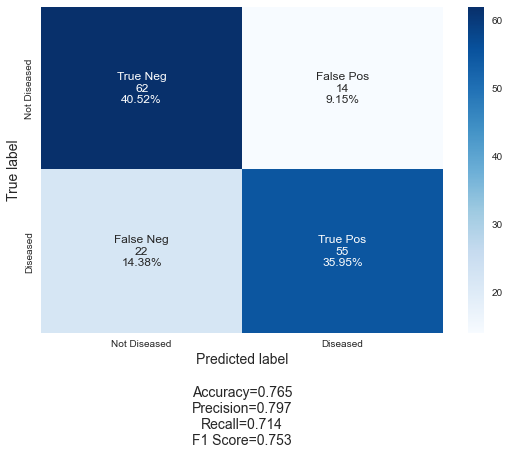

              precision    recall  f1-score   support

Not Diseased       0.74      0.82      0.78        76
    Diseased       0.80      0.71      0.75        77

    accuracy                           0.76       153
   macro avg       0.77      0.77      0.76       153
weighted avg       0.77      0.76      0.76       153



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,0.752,0.765,-0.01
1,PRECISION,0.878,0.797,0.08
2,RECALL,0.610,0.714,-0.10
3,F1 SCORE,0.720,0.753,-0.03
4,AUC,0.759,0.765,-0.01


In [38]:
# Predicting target for X_train and X_test
y_pred = LRmodel.predict(X_test)
y_pred_train = LRmodel.predict(X_train)

# Getting model scores
value_train = round(LRmodel.score(X_train, y_train), 3)
value_test = round(LRmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

In [38]:
# Stratifying data with Shuffle split & feature selection
evaluate_model(LRmodel, X_train,y_train)

# Predicting again target for X_train and X_test 
y_pred = LRmodel.predict(X_test)
y_pred_train = LRmodel.predict(X_train)

# Getting new scores
value_train = round(LRmodel.score(X_train, y_train), 3)
value_test = round(LRmodel.score(X_test, y_test), 3)

# Comparing model results with stratified data & feature selection
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

,Measure,Train,Test,Difference
0,ACCURACY,0.771,0.706,0.07
1,PRECISION,0.890,0.815,0.08
2,RECALL,0.617,0.557,0.06
3,F1 SCORE,0.729,0.662,0.07
4,AUC,0.771,0.711,0.06


> ### K-Nearest Neighbor

The K-Nearest neighbors algorithm, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.

In [182]:
# Hiper Tuning K-Nearest Neighbor

# Setting params
parameters = {'n_neighbors' : list(range(1, 16)), 
              'p': [1, 2], # 1 - Manhatan Distance; 2 - Euclidean Distance
              'leaf_size' : (1, 5, 10, 25, 50),
              'weights' : ('uniform', 'distance'), 
              'algorithm' : ('auto', 'ball_tree', 'kd_tree', 'brute')
              }

# Checking best parameters by highest f1 score obtained
KN_gridsearch = GridSearchCV(KNeighborsClassifier(),parameters, scoring = 'f1', cv = 10)
KN_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(KN_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(KN_gridsearch.best_estimator_))



Grid search best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'} 

Grid search best parameters: KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)


In [39]:
# Creating KN Model
KNmodel = KNeighborsClassifier(n_neighbors = 1,
                               leaf_size = 1,
                               p = 1,
                               weights = 'uniform',
                               algorithm = 'auto')

KNmodel.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

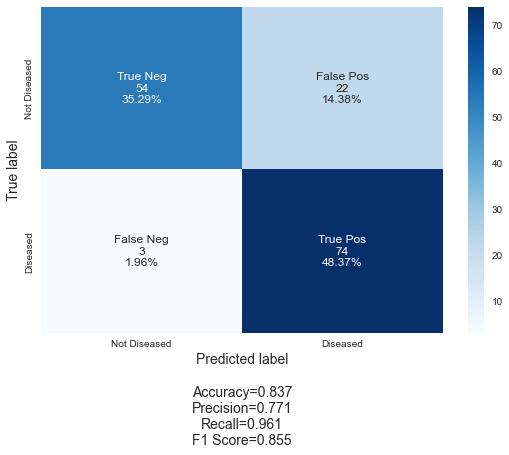

              precision    recall  f1-score   support

Not Diseased       0.95      0.71      0.81        76
    Diseased       0.77      0.96      0.86        77

    accuracy                           0.84       153
   macro avg       0.86      0.84      0.83       153
weighted avg       0.86      0.84      0.83       153



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.837,0.16
1,PRECISION,1.0,0.771,0.23
2,RECALL,1.0,0.961,0.04
3,F1 SCORE,1.0,0.855,0.15
4,AUC,1.0,0.836,0.16


In [40]:
# Predicting target for X_train and X_test
y_pred = KNmodel.predict(X_test)
y_pred_train = KNmodel.predict(X_train)

# Getting model scores
value_train = round(KNmodel.score(X_train, y_train), 3)
value_test = round(KNmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

In [41]:
# Stratifying data with Shuffle split & feature selection
evaluate_model(KNmodel, X_train,y_train)

# Predicting again target for X_train and X_test 
y_pred = KNmodel.predict(X_test)
y_pred_train = KNmodel.predict(X_train)

# Getting new scores
value_train = round(KNmodel.score(X_train, y_train), 3)
value_test = round(KNmodel.score(X_test, y_test), 3)

# Comparing model results with stratified data & feature selection
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

,Measure,Train,Test,Difference
0,ACCURACY,0.997,0.784,0.21
1,PRECISION,0.994,0.712,0.28
2,RECALL,1.000,0.961,0.04
3,F1 SCORE,0.997,0.818,0.18
4,AUC,0.997,0.783,0.21


In [42]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(KNmodel,
                            max_samples=.99,
                            max_features=.99,
                            n_estimators=5).fit(X_train, y_train)

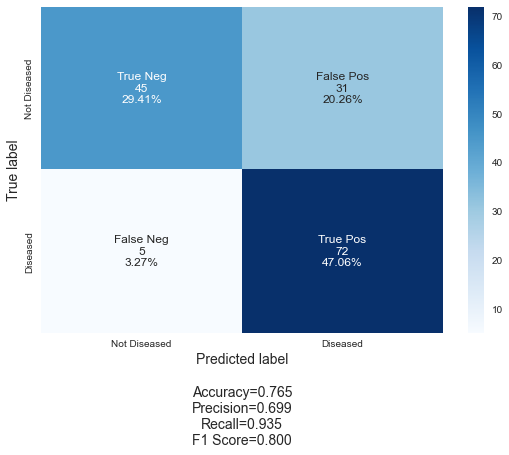

              precision    recall  f1-score   support

Not Diseased       0.90      0.59      0.71        76
    Diseased       0.70      0.94      0.80        77

    accuracy                           0.76       153
   macro avg       0.80      0.76      0.76       153
weighted avg       0.80      0.76      0.76       153



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,0.993,0.765,0.23
1,PRECISION,0.997,0.699,0.30
2,RECALL,0.991,0.935,0.06
3,F1 SCORE,0.994,0.800,0.19
4,AUC,0.994,0.764,0.23


In [43]:
# Predicting target for X_train and X_test
y_pred = bagging.predict(X_test)
y_pred_train = bagging.predict(X_train)

# Getting model scores
value_train = round(bagging.score(X_train, y_train), 3)
value_test = round(bagging.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

> ### Neural Network

A Neural Network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, Neural Networks refer to systems of neurons, either organic or artificial in nature.

In [ ]:
# Hiper Tuning Neural Network

# Setting params
parameters = {'hidden_layer_sizes': [(10), (50), (75), (100) , (120), (10, 10)],
              'activation': ('tanh', 'relu'),
              'solver': ('sgd', 'adam'),
              'learning_rate_init': list(np.linspace(.001, .1, 5)),
              'alpha' : (.0001, .05),
              'learning_rate': ('constant','adaptive')
              }

# Checking best parameters by highest f1 score obtained
NN_gridsearch = GridSearchCV(MLPClassifier(), parameters, scoring = 'f1', cv = 10)
NN_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(NN_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(NN_gridsearch.best_estimator_))

In [ ]:
# Setting params
parameters = {'learning_rate_init': list(np.linspace(.001, .1, 5)),
              'alpha' : (.0001, .05),
              'learning_rate': ('constant','adaptive')
              }

# Checking best parameters by highest f1 score obtained
NN_gridsearch = GridSearchCV(MLPClassifier(hidden_layer_sizes = 75,
                                           learning_rate = 'constant',
                                           activation = 'tanh',), parameters, scoring = 'f1', cv = 10)
NN_gridsearch.fit(X_train, y_train)

print('\n\nGrid search best parameters: {}'.format(NN_gridsearch.best_params_),
      '\n\nGrid search best parameters: {}'.format(NN_gridsearch.best_estimator_))

In [44]:
# Creating NN Model
NNmodel = MLPClassifier(activation = 'tanh',
                        hidden_layer_sizes = 120, 
                        learning_rate = 'adaptive', 
                        learning_rate_init = .0505, 
                        solver = 'adam',
                        power_t = 1e-10,
                        max_iter = 500,
                        n_iter_no_change=1000,
                        random_state = seed)

NNmodel.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=120,
              learning_rate='adaptive', learning_rate_init=0.0505, max_iter=500,
              n_iter_no_change=1000, power_t=1e-10, random_state=0)

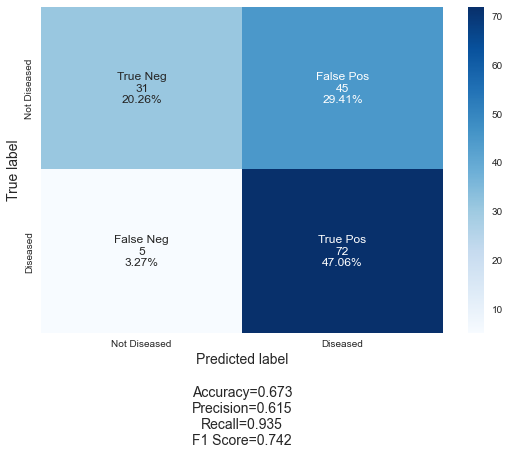

              precision    recall  f1-score   support

Not Diseased       0.86      0.41      0.55        76
    Diseased       0.62      0.94      0.74        77

    accuracy                           0.67       153
   macro avg       0.74      0.67      0.65       153
weighted avg       0.74      0.67      0.65       153



   Benchmarking Dataframe


,Measure,Train,Test,Difference
0,ACCURACY,1.0,0.673,0.33
1,PRECISION,1.0,0.615,0.38
2,RECALL,1.0,0.935,0.06
3,F1 SCORE,1.0,0.742,0.26
4,AUC,1.0,0.671,0.33


In [45]:
# Predicting target for X_train and X_test
y_pred = NNmodel.predict(X_test)
y_pred_train = NNmodel.predict(X_train)

# Getting model scores
value_train = round(NNmodel.score(X_train, y_train), 3)
value_test = round(NNmodel.score(X_test, y_test), 3)

# Creating confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred)

# Plot
make_confusion_matrix(cf, 
                      group_names = labels,
                      categories = categories,
                      figsize = (9,6))
plt.show()

# Creating classification report
print(classification_report(y_test, y_pred, target_names = categories))

# Metrics dataframe report
print('\n\n   Benchmarking Dataframe')
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

In [287]:
# Stratifying data with Shuffle split & feature selection
evaluate_model(NNmodel, X_train,y_train)

# Predicting again target for X_train and X_test 
y_pred = NNmodel.predict(X_test)
y_pred_train = NNmodel.predict(X_train)

# Getting new scores
value_train = round(NNmodel.score(X_train, y_train), 3)
value_test = round(NNmodel.score(X_test, y_test), 3)

# Comparing model results with stratified data & feature selection
display(performance_metrics(y_train, y_pred_train, y_test, y_pred))

,Measure,Train,Test,Difference
0,ACCURACY,0.997,0.942,0.06
1,PRECISION,0.997,0.961,0.04
2,RECALL,0.997,0.925,0.07
3,F1 SCORE,0.997,0.943,0.05
4,AUC,0.997,0.943,0.05
